# Investigating the data.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import corner
import stardate2 as sd2
import emcee
import stardate as sd
from stardate import load_samples, read_samples

plotpar = {'axes.labelsize': 30,
           'font.size': 22,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
df = pd.read_csv("../data/for_ruth_masses.csv")
df = df.iloc[np.isfinite(df.gaia_parallax.values)]
df.keys()

Index(['dr25_kepid', 'prot', 'prot_err1', 'prot_err2', 'Prot_flag',
       'a18_period', 'a18_period_errm', 'a18_period_errp', 'm15_Prot',
       'm15_e_Prot', 'm15_Rvar', 'm15_Prot.1', 'm15_e_Prot.1', 'm15_LPH',
       'm15_w', 'm15_C', 'm15_R', 'm13_Prot', 'm13_e_Prot', 'm13_Rvar',
       'm13_Flag', 'p20_cks_steff', 'p20_cks_steff_err1', 'p20_cks_steff_err2',
       'p20_cks_slogg', 'p20_cks_slogg_err1', 'p20_cks_slogg_err2',
       'p20_cks_smet', 'p20_cks_smet_err1', 'p20_cks_smet_err2',
       'p20_cks_svsini', 'p20_cks_svsini_err1', 'p20_cks_svsini_err2',
       'f18_logAiso', 'f18_e_logAiso', 'f18_E_logAiso', 'f18_Miso',
       'f18_e_Miso', 'f18_E_Miso', 'b20_log10_iso_age', 'b20_E_log10_iso_age',
       'b20_e_log10_iso_age', 'b20_iso_mass', 'b20_iso_mass_err1',
       'b20_iso_mass_err2', 'gaia_parallax', 'gaia_parallax_error',
       'gaia_phot_g_mean_mag', 'gaia_phot_g_mean_flux',
       'gaia_phot_g_mean_flux_error', 'gaia_phot_bp_mean_mag',
       'gaia_phot_bp_mean_flux

In [3]:
N = len(df)
print(N)

879


In [4]:
def abs_mag(m, D):
    return m - 5*np.log10(D) + 5

MG = abs_mag(df.gaia_phot_g_mean_mag.values, 1./df.gaia_parallax.values*1e3)
df["MG"] = MG

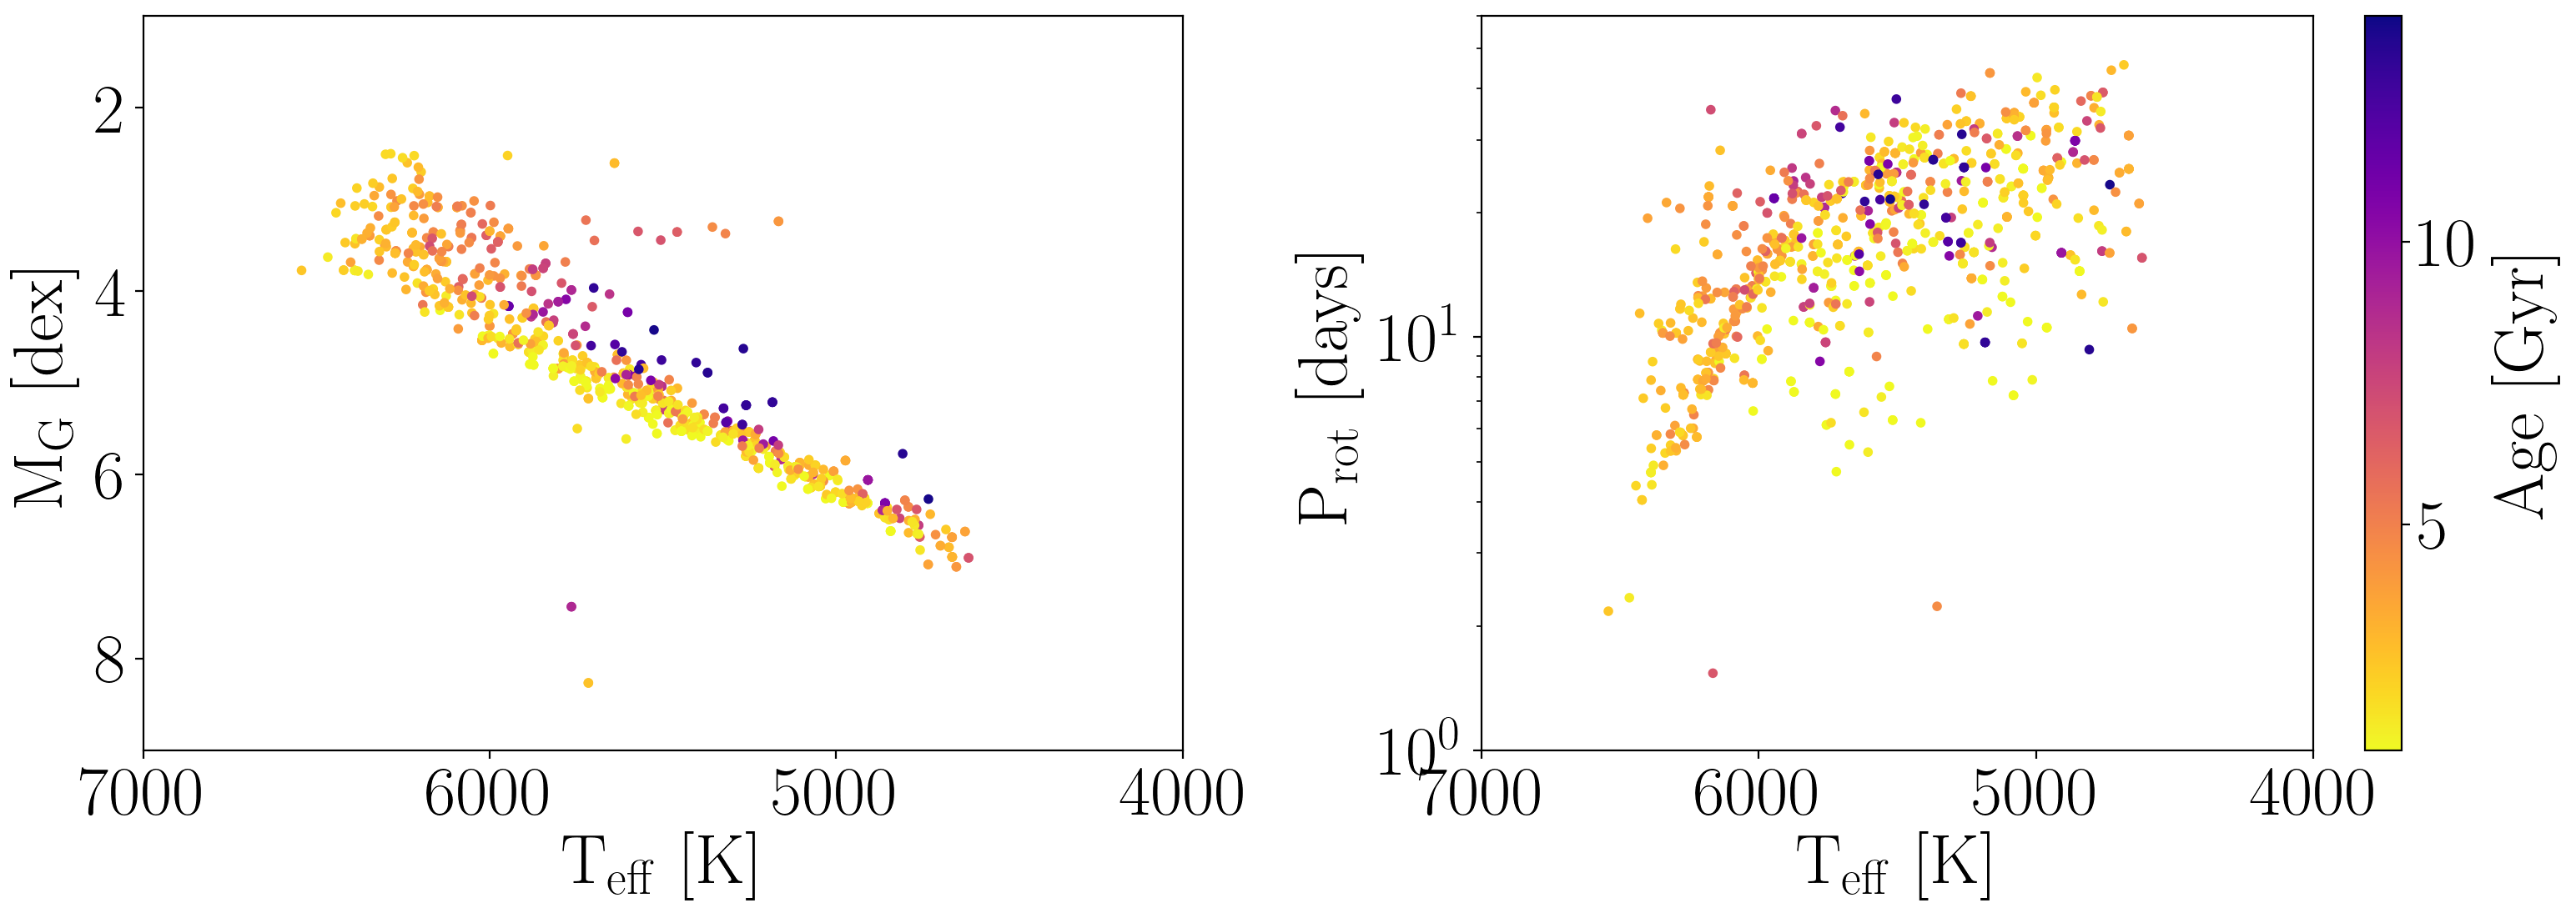

In [5]:
fig = plt.figure(figsize=(16, 6), dpi=200)

ax1 = fig.add_subplot(121)
cb = ax1.scatter(df.p20_cks_steff.values, df.MG.values, c=1e-9*(10**df.f18_logAiso.values),
                 vmin=1, vmax=14, cmap="plasma_r", s=10, zorder=0)
ax1.set_xlim(7000, 4000)
ax1.set_ylim(9, 1)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")

ax2 = fig.add_subplot(122)
cb = ax2.scatter(df.p20_cks_steff, df.prot, c=1e-9*(10**df.f18_logAiso.values),
                 vmin=1, vmax=14, cmap="plasma_r", s=10, zorder=0)#, alpha=.5)
ax2.set_xlim(7000, 4000)
ax2.set_ylim(1, 60)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")

plt.colorbar(cb, label="$\mathrm{Age~[Gyr]}$")
plt.tight_layout()

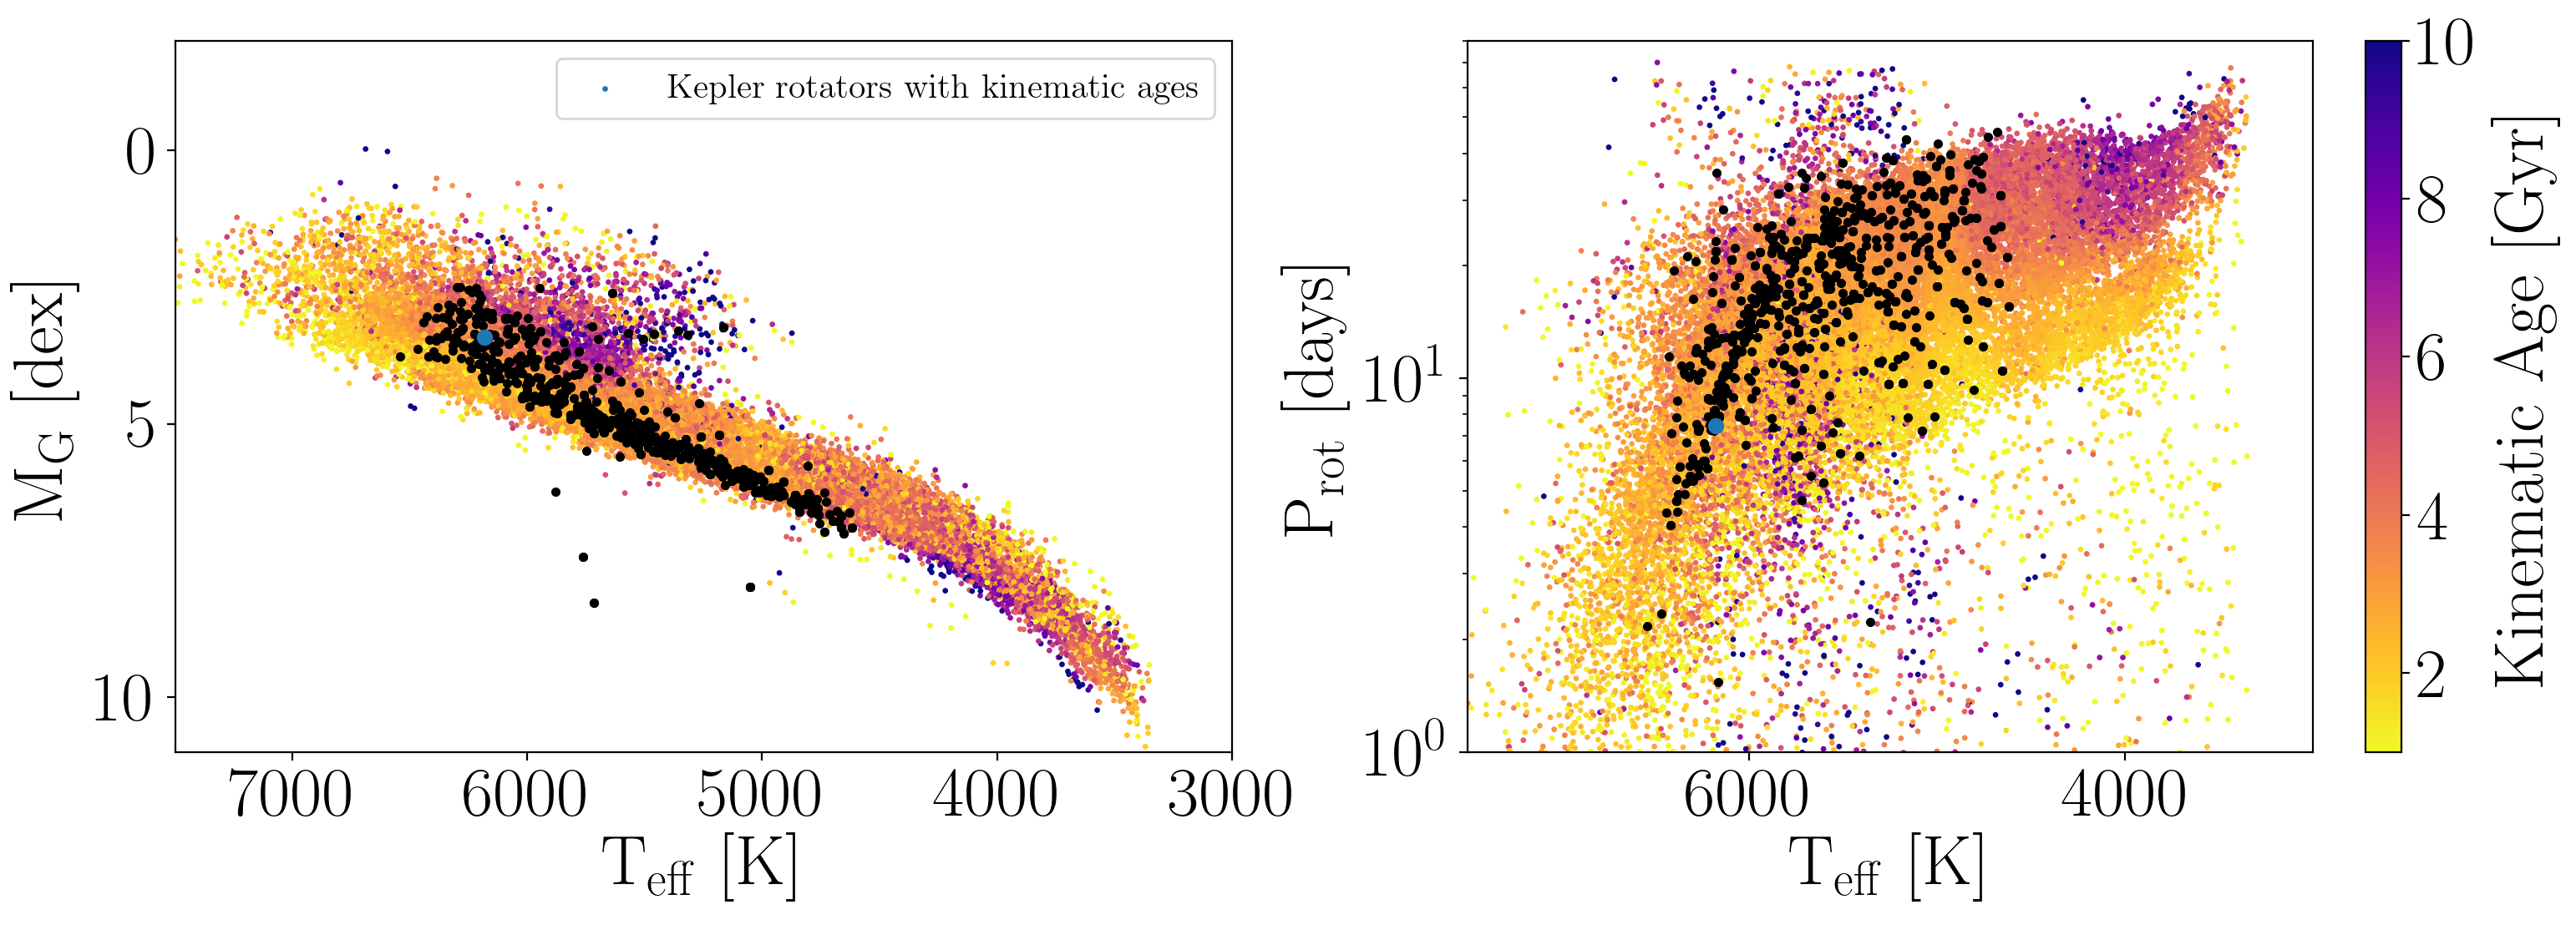

In [6]:
bdf = pd.read_csv("../../data/bokeh_df.csv")

fig = plt.figure(figsize=(16, 6), dpi=200)
ax1 = fig.add_subplot(121)
ax1.scatter(bdf.teff, bdf.M_G, c=bdf.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0,
            label="$\mathrm{Kepler~rotators~with~kinematic~ages}$")#, alpha=.5)
ax1.plot(df.p20_cks_steff.values, df.MG.values, "k.", zorder=1)
ax1.plot(df.p20_cks_steff.values[0], df.MG.values[0], "o", zorder=2)
ax1.set_xlim(7500, 3000)
ax1.set_ylim(11, -2)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")
ax1.legend()

ax2 = fig.add_subplot(122)
cb = ax2.scatter(bdf.teff, bdf.prot, c=bdf.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax2.plot(df.p20_cks_steff, df.prot, "k.", zorder=1)
ax2.plot(df.p20_cks_steff.values[0], df.prot.values[0], "o", zorder=2)
ax2.set_xlim(7500, 3000)
ax2.set_ylim(1, 80)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")

plt.colorbar(cb, label="$\mathrm{Kinematic~Age~[Gyr]}$")
plt.tight_layout()

Test stardate on one star. First, let's calculate an age using rotation periods and gyrochronology only. 

In [7]:
teff_err = .5*(df.p20_cks_steff_err1.values - df.p20_cks_steff_err2.values)
feh_err = .5*(df.p20_cks_smet_err1.values - df.p20_cks_smet_err2.values)
prot_err = .5*(df.prot_err1.values - df.prot_err2.values)
av_err = .5*(df.l20_Av_errp.values + df.l20_Av_errm.values)
bprp = df.gaia_phot_bp_mean_mag.values - df.gaia_phot_rp_mean_mag.values
av = df.l20_Av.values
av[av == 0] = np.ones(sum(av == 0))*.1

In [8]:
i = 0

In [9]:
ndim, nwalkers = 1, 25
p0 = np.random.randn(nwalkers, ndim)*1e-2 + 9
sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[df.prot.values[i], prot_err[i], bprp[i], sd2.angus_2019_model])

state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000);

Age = 1.14 + 0.06 - 0.06 Gyr


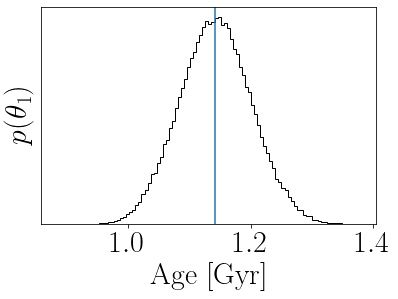

In [10]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"Age = {median_age:.2f} + {errp:.2f} - {errm:.2f} Gyr")

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Now an age using isochrones only (no gyrochronology).

In [11]:
# Create a dictionary of observables
iso_params = {"teff": (df.p20_cks_steff.values[i], teff_err[i]),
              "feh": (df.p20_cks_smet.values[i], feh_err[i]),
              "G": (df.gaia_phot_g_mean_mag.values[i], .01),
              "parallax": (df.gaia_parallax.values[i], df.gaia_parallax_error.values[i])}
iso_params

{'teff': (6181.3, 60.0),
 'feh': (-0.084, 0.04),
 'G': (13.529923000000002, 0.01),
 'parallax': (0.9497577284262304, 0.01385262138937004)}

Calculate initial parameters.

In [12]:
from isochrones import get_ichrone
tracks = get_ichrone('mist', tracks=True)

mass, age, feh = (df.f18_Miso.values[i], df.f18_logAiso.values[i], df.p20_cks_smet.values[i])

track = tracks.generate(mass, age, feh, return_dict=True)  # "accurate=True" makes more accurate, but slower
EEP_init = track["eep"]

inits = [EEP_init, df.f18_logAiso.values[i], df.p20_cks_smet.values[i], 1./(df.gaia_parallax.values[i]*1e-3), df.l20_Av.values[i]]
print(inits)
print(1e-9*(10**df.f18_logAiso.values[i]))

[425.826, 9.67, -0.084, 1052.9000923814772, 0.1919399957098067]
4.677351412871982


In [29]:
# Set up the star object.
fn = "{}_iso".format(int(df.dr25_kepid.values[i]))
star1 = sd.Star(iso_params, prot=None, prot_err=None, Av=df.l20_Av.values[i], Av_err=av_err[i], filename=fn)

# Run the MCMC
star1.fit(inits=inits, max_n=50000, burnin=1000, save_samples=True)

  0%|          | 12/50000 [00:00<07:29, 111.24it/s]

Automatically setting burn in to 166


100%|██████████| 50000/50000 [06:58<00:00, 119.60it/s]

nsteps 500 burnin 166


In [33]:
# Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star1.age_results(burnin=1)
print("stellar age = {0:.2f} + {1:.2f} + {2:.2f}".format(age, errp, errm))

stellar age = 4.11 + 2.49 + 2.63


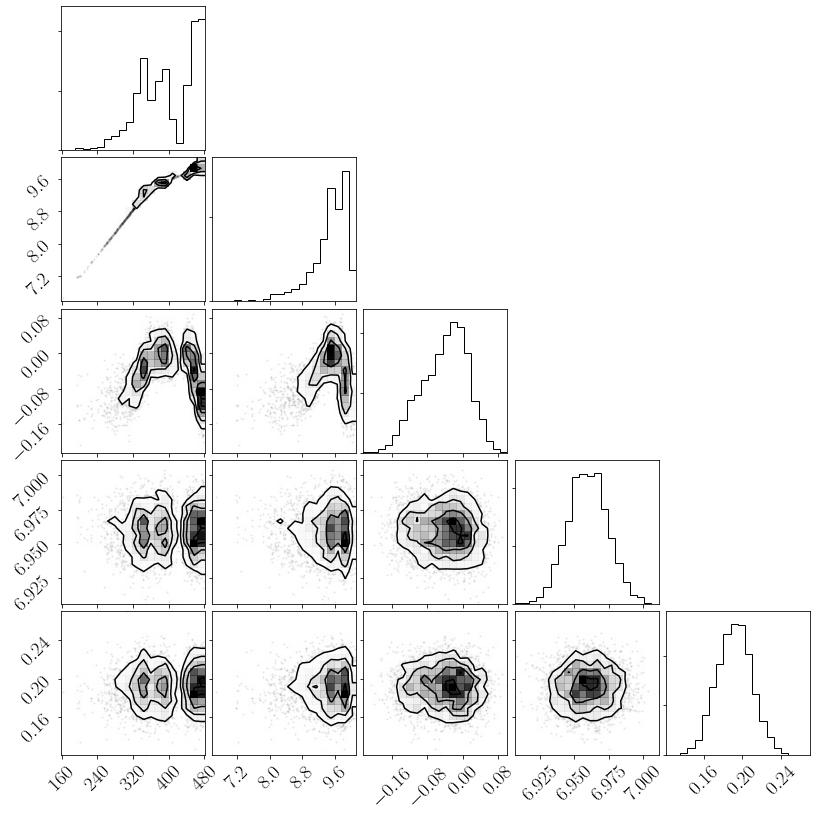

In [35]:
plotpar = {'xtick.labelsize': 20,
           'ytick.labelsize': 20}
plt.rcParams.update(plotpar)

corner.corner(star1.samples[::5]);

Now with gyrochronology.

In [47]:
# Let's recalculate the initial parameters based on the isochrones-only fit.
best = np.median(star1.samples, axis=0)
print(best)

from stardate import load_samples, read_samples

# Load the samples.
fn = "{}_iso.h5".format(df.dr25_kepid.values[i])
flatsamples, _3Dsamples, posterior_samples, prior_samples = load_samples(fn, burnin=0)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)
best = [float(results.EEP_ml.values), np.log10(1e9*float(results.age_ml_gyr.values)), float(results.feh_ml.values),
        float(results.distance_ml.values), float(results.Av_ml.values)]
print(best)

[ 3.92940320e+02  9.56131092e+00 -3.51468021e-02  6.95950764e+00
  1.91779330e-01]
[351.9900013701296, 9.34374410922856, -0.016697216421709273, 1053.0175645895185, 0.19385579311026954]


In [48]:
# Set up the star object.
star = sd.Star(iso_params, prot=df.prot.values[i], prot_err=prot_err[i],
               Av=df.l20_Av.values[i], Av_err=av_err[i])

# Run the MCMC
star.fit(inits=best, max_n=50000, burnin=1000)

  0%|          | 7/50000 [00:00<13:41, 60.89it/s]

Automatically setting burn in to 166


100%|██████████| 50000/50000 [14:14<00:00, 58.51it/s]


nsteps 50000 burnin 166


In [49]:
# Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star.age_results(burnin=1000)
print("stellar age = {0:.2f} + {1:.2f} + {2:.2f}".format(age, errp, errm))

stellar age = 2.42 + 0.11 + 0.12


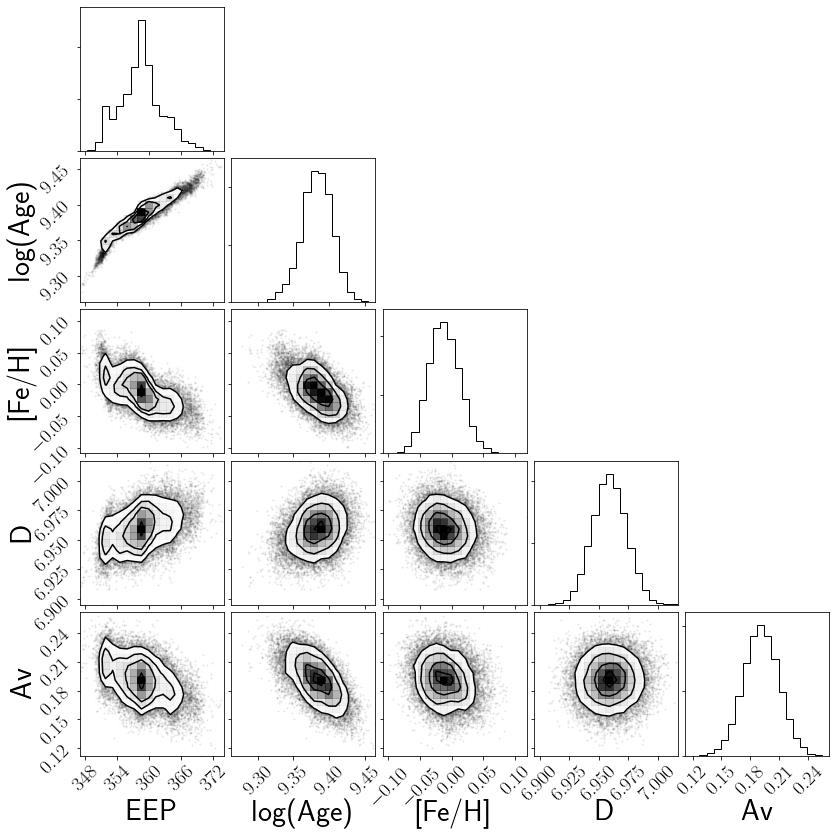

In [50]:
corner.corner(star.samples[::100], labels=["EEP", "log(Age)", "[Fe/H]", "D", "Av"]);

# Let's try a cooler star where the gyrochronology should be more important.

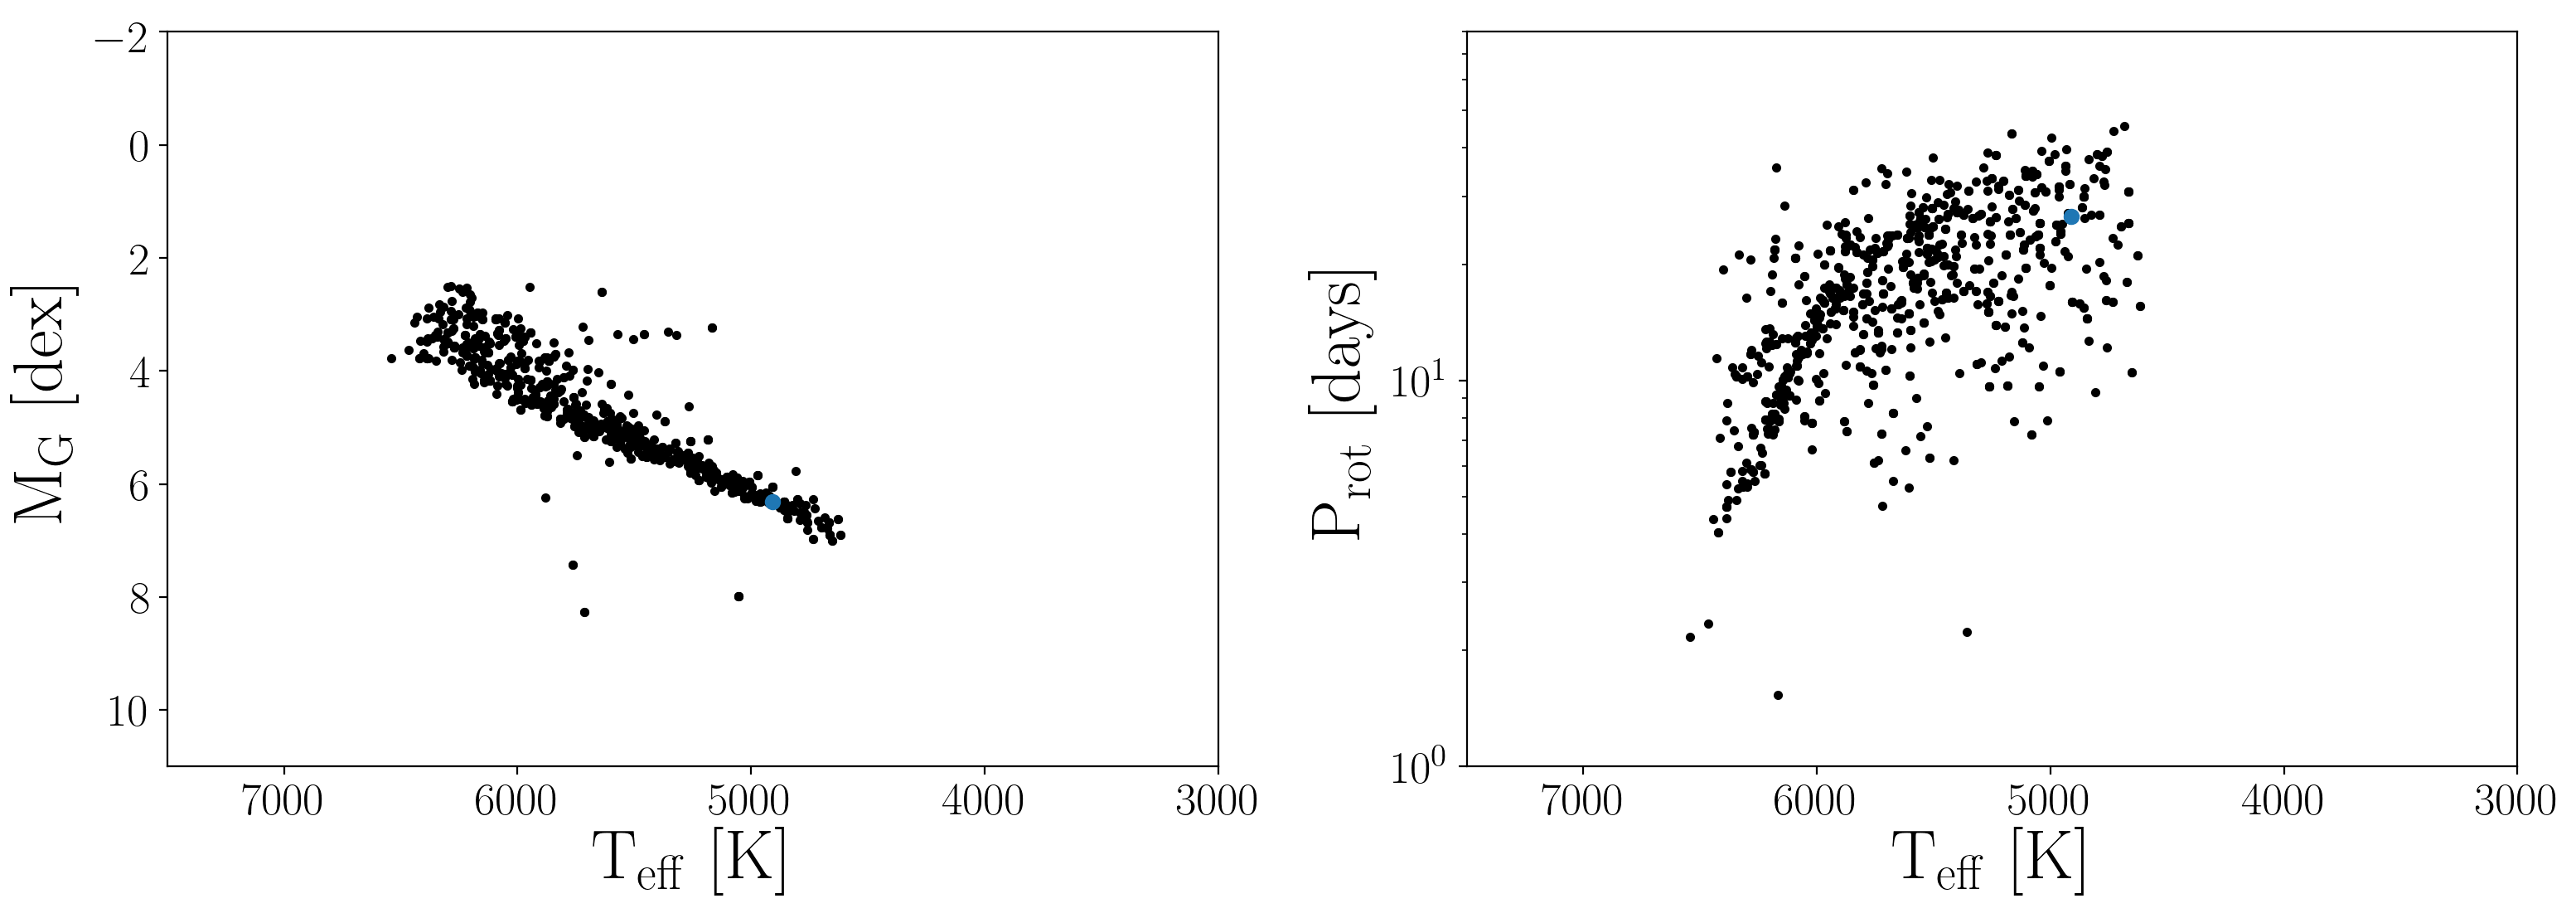

In [51]:
i = 9

fig = plt.figure(figsize=(16, 6), dpi=200)
ax1 = fig.add_subplot(121)
ax1.plot(df.p20_cks_steff.values, df.MG.values, "k.", zorder=1)
ax1.plot(df.p20_cks_steff.values[i], df.MG.values[i], "o", zorder=2)
ax1.set_xlim(7500, 3000)
ax1.set_ylim(11, -2)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")

ax2 = fig.add_subplot(122)
ax2.plot(df.p20_cks_steff, df.prot, "k.", zorder=1)
ax2.plot(df.p20_cks_steff.values[i], df.prot.values[i], "o", zorder=2)
ax2.set_xlim(7500, 3000)
ax2.set_ylim(1, 80)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")

plt.tight_layout()

First gyro only.

In [58]:
#get inits
tracks = get_ichrone('mist', tracks=True)

mass, age, feh = (df.f18_Miso.values[i], df.f18_logAiso.values[i], df.p20_cks_smet.values[i])

track = tracks.generate(mass, age, feh, return_dict=True)  # "accurate=True" makes more accurate, but slower
EEP_init = track["eep"]

inits = [EEP_init, df.f18_logAiso.values[i], df.p20_cks_smet.values[i], 1./(df.gaia_parallax.values[i]*1e-3), .1] # df.l20_Av.values[i]]
print(inits)
print("Init age = ", 1e-9*(10**df.f18_logAiso.values[i]))

[284.12, 9.03, 0.109, 108.13330268669024, 0.1]
Init age =  1.0715193052376049


In [53]:
ndim, nwalkers = 1, 25
p0 = np.random.randn(nwalkers, ndim)*1e-2 + inits[1]

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[df.prot.values[i], prot_err[i], bprp[i], sd2.angus_2019_model])

state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000);

Age = 2.64 + 0.03 - 0.03 Gyr


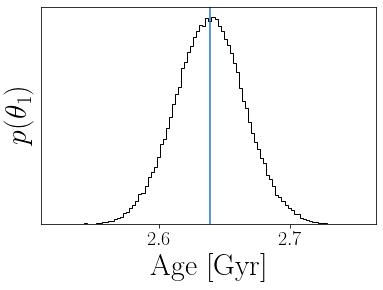

In [54]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"Age = {median_age:.2f} + {errp:.2f} - {errm:.2f} Gyr")

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Now without gyro:

In [73]:
# Create a dictionary of observables
iso_params = {"teff": (df.p20_cks_steff.values[i], teff_err[i]),
              "feh": (df.p20_cks_smet.values[i], feh_err[i]),
              "G": (df.gaia_phot_g_mean_mag.values[i], .01),
              "parallax": (df.gaia_parallax.values[i], df.gaia_parallax_error.values[i])}

# Set up the star object.
fn = "{}_iso".format(int(df.dr25_kepid.values[i]))
star1 = sd.Star(iso_params, prot=None, prot_err=None, Av=av[i], Av_err=av_err[i], filename=fn)
# star1 = sd.Star(iso_params, prot=None, prot_err=None, Av=df.l20_Av.values[i], Av_err=av_err[i], filename=fn)

# Run the MCMC
star1.fit(inits=inits, max_n=10000, burnin=1, save_samples=True)

# Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star1.age_results(burnin=1)
print("stellar age = {0:.2f} + {1:.2f} + {2:.2f}".format(age, errp, errm))

100%|██████████| 10000/10000 [00:51<00:00, 194.28it/s]

nsteps 100 burnin 1
stellar age = 1.07 + 0.00 + 0.00


In [74]:
inits

[284.12, 9.03, 0.109, 108.13330268669024, 0.1]

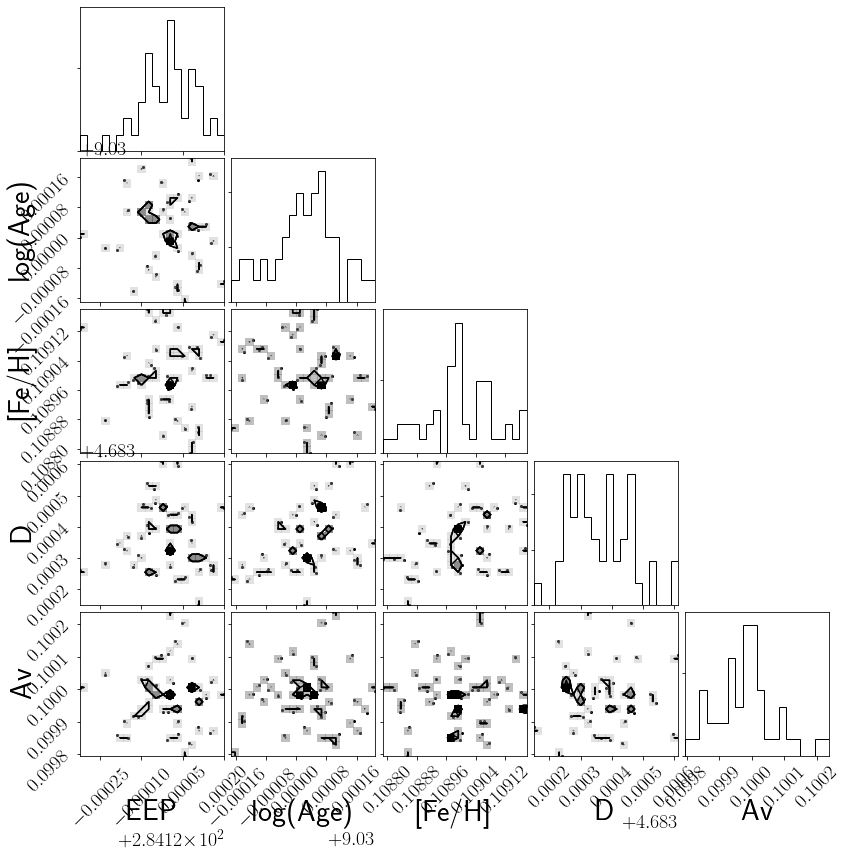

In [75]:
corner.corner(star1.samples[::1], labels=["EEP", "log(Age)", "[Fe/H]", "D", "Av"]);

In [56]:
# Let's recalculate the initial parameters based on the isochrones-only fit.

# Load the samples.
fn = "{}_iso.h5".format(df.dr25_kepid.values[i])
flatsamples, _3Dsamples, posterior_samples, prior_samples = load_samples(fn, burnin=0)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)
best = [float(results.EEP_ml.values), np.log10(1e9*float(results.age_ml_gyr.values)), float(results.feh_ml.values),
        float(results.distance_ml.values), float(results.Av_ml.values)]
print(best)

AttributeError: You must run the sampler with 'store == True' before accessing the results

And with gyro.

In [158]:
# Set up the star object.
star = sd.Star(iso_params, prot=df.prot.values[i], prot_err=prot_err[i],
               Av=df.l20_Av.values[i], Av_err=av_err[i])

# Run the MCMC
star.fit(inits=inits, max_n=50000, burnin=1000)

# Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star.age_results(burnin=1000)
print("stellar age = {0:.2f} + {1:.2f} + {2:.2f}".format(age, errp, errm))

  0%|          | 0/50000 [00:00<?, ?it/s]

Automatically setting burn in to 166


100%|██████████| 50000/50000 [04:33<00:00, 182.90it/s]


nsteps 50000 burnin 166
stellar age = 1.07 + 0.00 + 0.00


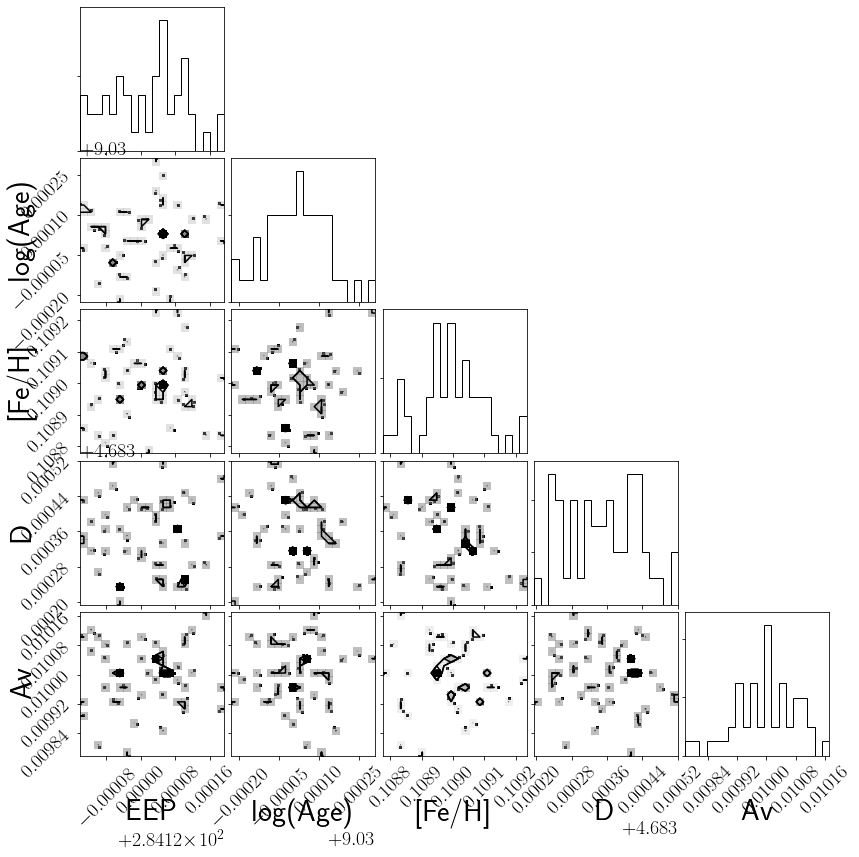

In [159]:
corner.corner(star.samples[::100], labels=["EEP", "log(Age)", "[Fe/H]", "D", "Av"]);